In [1]:
import os
import copy
import numpy as np
import pandas as pd
import seaborn

from IFdensity.contam_sm_de import *
from IFdensity.influence_function import *

from IPython.display import Markdown as md

In [2]:
os.chdir('/Users/chenxizhou/Dropbox/code_package/IFdensity')
true_data = np.load('data/geyser.npy').astype(np.float64)
df = copy.deepcopy(true_data[:, 0]).reshape(-1, 1)

# original data with 108.0 removed 
data_waiting = df[df != 108.0]

# bandwidth parameter in the Gaussian kernel function
bw = 7.0

# penalty parameter 
log_pen_param = -10.0

# base density 
base_density = BasedenGamma(np.load('data/geyser.npy').astype(np.float64)[:, 0])

plot_kwargs = plot_IF_1d_params(x_limit=(21., 410.), plot_pts_cnt = 2000)

--------------------------------------------------
Current contaminated data point is 110.0.


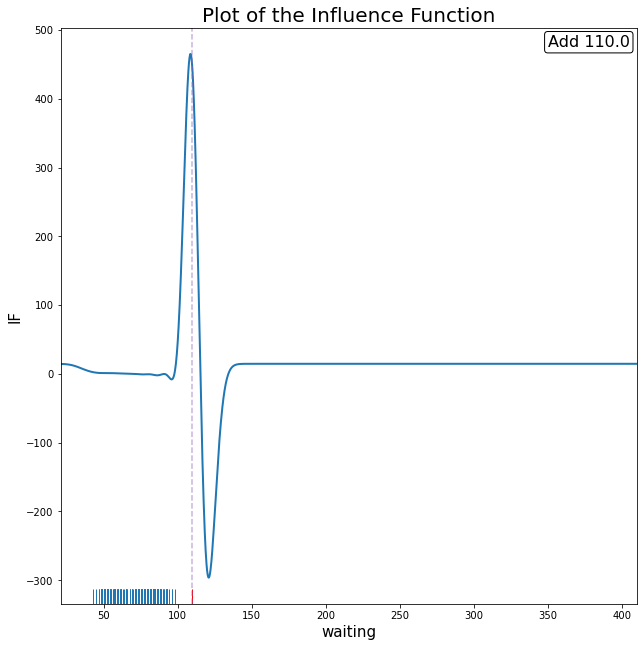

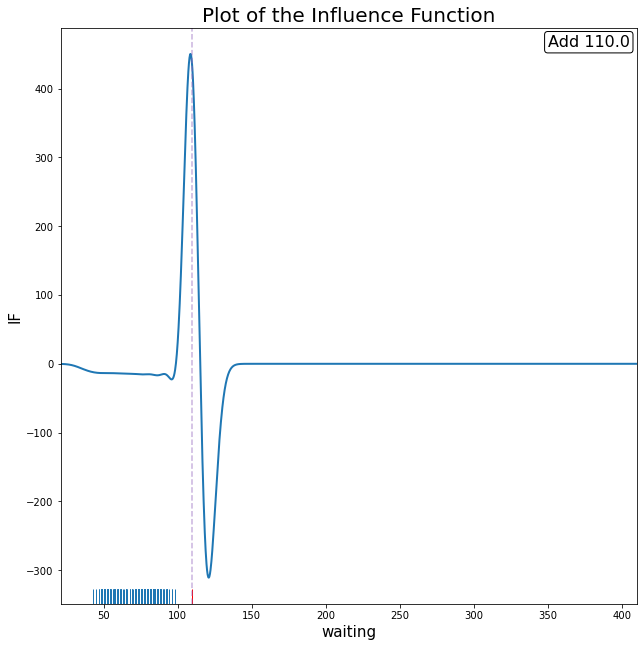

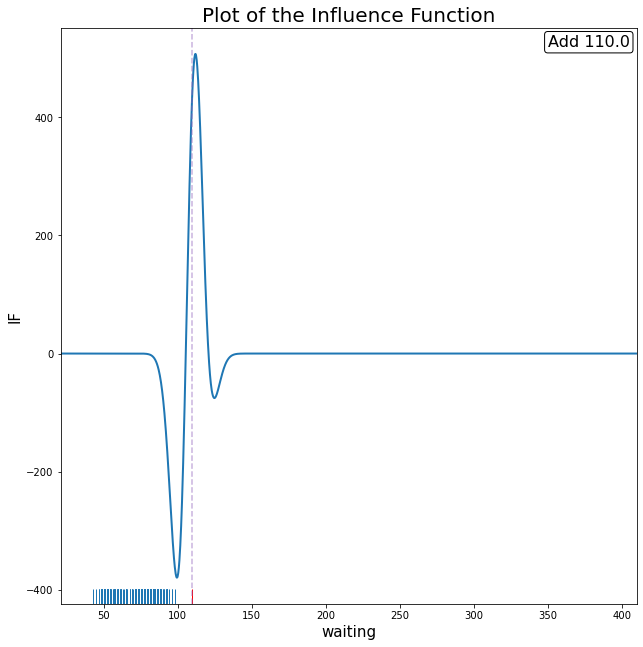

In [4]:
# contaminated data 
contam_data_list = np.array([110.]) # np.arange(., 410., 10)
for contam_pt in contam_data_list: 
    
    print('-' * 50)
    print(f'Current contaminated data point is {contam_pt}.')
    
    contam_data = np.array([[contam_pt]])
    
    ifun = SMInfluenceFunction(
        data = data_waiting, 
        contam_data = contam_data, 
        contam_weight = 1e-8, 
        penalty_param = np.exp(log_pen_param), 
        base_density = base_density, 
        bw = bw)
    
    if_vals0 = ifun.plot_IF_logdensity_1d(
        plot_kwargs = plot_kwargs, 
        x_label = 'waiting')
    
    if_vals = ifun.plot_IF_natparam_1d(
        plot_kwargs = plot_kwargs, 
        x_label = 'waiting')
    
    if_vals1 = ifun.plot_IF_natparam_limit_1d(
        plot_kwargs = plot_kwargs, 
        x_label = 'waiting')
    

In [ ]:
if_vals0

In [ ]:
np.sort(np.unique(data_waiting.flatten())).shape

In [ ]:
data_waiting_pur = data_waiting.flatten() + np.random.randn(len(data_waiting)) / 10.
data_waiting_pur

In [ ]:
np.max(np.abs(data_waiting - data_waiting_pur))

In [ ]:
def eval_IF_natparam_contam_data_array(data, new_data, contam_data_array, contam_weight, penalty_param, base_density,
                                         r1=1.0, r2=0., c=0., bw=1.0, kernel_type='gaussian_poly2',
                                         save_data=False, save_dir=None):

    if contam_weight == 0.:
        raise ValueError('In order to compute the influence function, contam_weight cannot be 0.')

    # check the validity of the contam_data_array
    if not isinstance(contam_data_array, np.ndarray):
        raise TypeError(f'contam_data_array must be a numpy.ndarray, but got {type(contam_data_array)}.')

    # check the compatibility of data and new_data
    if not isinstance(data, np.ndarray):
        data = np.array(data)

    if not isinstance(new_data, np.ndarray):
        new_data = np.array(new_data)

    if len(data.shape) == 1:
        data = data.reshape(-1, 1)

    if len(new_data.shape) == 1:
        new_data = new_data.reshape(-1, 1)

    N, d = data.shape
    n, d1 = new_data.shape
    if d != d1:
        raise ValueError('data and new_data are not compatible.')

    # check the compatibility of data and contam_data_array
    if len(contam_data_array.shape) == 1:
        contam_data_array = contam_data_array.reshape(-1, 1)
    if contam_data_array.shape[1] != d:
        raise ValueError('contam_data_array are not compatible with data and new_data.')

    print('-' * 50)
    print('Computing the uncontaminated log-density values.')
    # compute the log-density values of the uncontaminated data
    uncontam_den = ContamSMDensityEstimate(
        data=data,
        contam_data=contam_data_array[0].reshape(1, d),
        contam_weight=contam_weight,
        penalty_param=penalty_param,
        base_density=base_density,
        r1=r1,
        r2=r2,
        c=c,
        bw=bw,
        kernel_type=kernel_type)

    uncontam_logdenvals_new = uncontam_den.log_density(new_data=new_data)
    uncontam_logdenvals_contam = uncontam_den.log_density(new_data=contam_data_array)

    # save data
    if save_data:
        full_save_folder = 'data/' + save_dir
        if not os.path.isdir(full_save_folder):
            os.mkdir(full_save_folder)

        file_name_newdata = f'/new_data.npy'
        np.save(full_save_folder + file_name_newdata, new_data)

        file_name_diff = f'/uncontam-logden-newdata.npy'
        np.save(full_save_folder + file_name_diff, uncontam_logdenvals_new)

        file_name_contamdata = f'/contam_data.npy'
        np.save(full_save_folder + file_name_contamdata, contam_data_array)

        file_name_logden_contam = f'/uncontam-logden-contamdata.npy'
        np.save(full_save_folder + file_name_logden_contam, uncontam_logdenvals_contam)

    IF_output_new = {}
    IF_output_new['new_data'] = new_data
    IF_output_new['contam_data'] = contam_data_array

    IF_output_contam = {}

    for i in range(len(contam_data_array)):

        print('-' * 50)
        print(f'Computing the contaminated log-density values ')
        print(f'with the current contaminated data point being {contam_data_array[i]}.')

        contam_den = ContamSMDensityEstimate(
            data=data,
            contam_data=contam_data_array[i].reshape(1, d),
            contam_weight=contam_weight,
            penalty_param=penalty_param,
            base_density=base_density,
            r1=r1,
            r2=r2,
            c=c,
            bw=bw,
            kernel_type=kernel_type)

        contam_logdenvals_new = contam_den.log_density(new_data=new_data)
        contam_logdenvals_contam = contam_den.log_density(new_data=contam_data_array)

        IF_newdata = (contam_logdenvals_new - uncontam_logdenvals_new) / contam_weight
        IF_output_new['contam ' + str(contam_data_array[i])] = IF_newdata

        IF_contam = (contam_logdenvals_contam - uncontam_logdenvals_contam) / contam_weight
        IF_output_contam['contam ' + str(contam_data_array[i])] = IF_contam

        if save_data:
            file_name_diff = f'/contam_data={contam_data_array[i]}-contam-logden-newdata.npy'
            np.save(full_save_folder + file_name_diff, contam_logdenvals_new)

            file_name_logden_contam = f'/contam_data={contam_data_array[i]}-contam-logden-contamdata.npy'
            np.save(full_save_folder + file_name_logden_contam, contam_logdenvals_contam)

            IF_file_name_new = f'/contam_data={contam_data_array[i]}-IF-logden-newdata.npy'
            np.save(full_save_folder + IF_file_name_new, IF_newdata)

            IF_file_name_contam = f'/contam_data={contam_data_array[i]}-IF-logden-contamdata.npy'
            np.save(full_save_folder + IF_file_name_contam, IF_contam)

    # form the final output of influence function at contam_data_list
    IF_contam_list = []
    for i in range(len(contam_data_array)):
        IF_contam_list.append(IF_output_contam['contam ' + str(contam_data_array[i])])

    IF_contam_diag = np.diag(np.array(IF_contam_list))
    IF_contam_final_output = {'contam_data': contam_data_array, 'IF_vals': IF_contam_diag}

    return IF_output_new, IF_contam_final_output
